In [1]:
import pandas as pd
import numpy as np
import pyspark
from pyspark.sql import SparkSession, DataFrameReader, SQLContext
from pyspark import SparkContext
from pyspark.sql.functions import col, format_string, date_format, format_number, to_date
import re
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

## Create Spark Session

In [2]:
spark = SparkSession.builder \
    .appName('Airports_analyse') \
    .config('spark.jars', 'gs://spark-lib/bigquery/spark-3.1-bigquery-0.28.0-preview.jar') \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/09 18:53:50 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/03/09 18:53:50 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/03/09 18:53:50 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/03/09 18:53:51 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


## Connect to Bigquery tables

In [3]:
aircrafts_data_df = spark.read \
    .format('com.google.cloud.spark.bigquery') \
    .option('table', 'flights_database.aircrafts_data') \
    .load()

airports_data_df = spark.read \
    .format('com.google.cloud.spark.bigquery') \
    .option('table', 'flights_database.airports_data') \
    .load()

boarding_passes_df = spark.read \
    .format('com.google.cloud.spark.bigquery') \
    .option('table', 'flights_database.boarding_passes') \
    .load()

bookings_df = spark.read \
    .format('com.google.cloud.spark.bigquery') \
    .option('table', 'flights_database.bookings') \
    .load()

flights_df = spark.read \
    .format('com.google.cloud.spark.bigquery') \
    .option('table', 'flights_database.flights') \
    .load()

seats_df = spark.read \
    .format('com.google.cloud.spark.bigquery') \
    .option('table', 'flights_database.seats') \
    .load()

ticket_flights_df = spark.read \
    .format('com.google.cloud.spark.bigquery') \
    .option('table', 'flights_database.ticket_flights') \
    .load()

tickets_df = spark.read \
    .format('com.google.cloud.spark.bigquery') \
    .option('table', 'flights_database.tickets') \
    .load()

## Simplify airport DataFrame to have only english names of airport and city

In [4]:
simplify_airport_df=airports_data_df.rdd.map(
    lambda x: (
        x.airport_code,
        re.findall(r'"(.*?)"', x.airport_name)[1],
        re.findall(r'"(.*?)"', x.city)[1],
        x.coordinates,
        x.timezone,
        float(re.findall(r'\d+.\d+', x.coordinates)[0]),
        float(re.findall(r'\d+.\d+', x.coordinates)[1])
    )
)

simplify_airport_df=simplify_airport_df.toDF(
    [
        "airport_code", "airport_name", "city", "coordinates", "timezone", "long", "lat",
    ]
)

airports_df = simplify_airport_df.toPandas()

airports_df

,airport_code,airport_name,city,coordinates,timezone,long,lat
0,YKS,Yakutsk Airport,Yakutsk,"(129.77099609375,62.0932998657226562)",Asia/Yakutsk,129.770996,62.093300
1,MJZ,Mirny Airport,Mirnyj,"(114.03900146484375,62.534698486328125)",Asia/Yakutsk,114.039001,62.534698
2,KHV,Khabarovsk-Novy Airport,Khabarovsk,"(135.18800354004,48.5279998779300001)",Asia/Vladivostok,135.188004,48.528000
3,PKC,Yelizovo Airport,Petropavlovsk,"(158.453994750976562,53.1679000854492188)",Asia/Kamchatka,158.453995,53.167900
4,UUS,Yuzhno-Sakhalinsk Airport,Yuzhno-Sakhalinsk,"(142.718002319335938,46.8886985778808594)",Asia/Sakhalin,142.718002,46.888699
...,...,...,...,...,...,...,...
99,ABA,Abakan Airport,Abakan,"(91.3850021362304688,53.7400016784667969)",Asia/Krasnoyarsk,91.385002,53.740002
100,BAX,Barnaul Airport,Barnaul,"(83.5384979248046875,53.363800048828125)",Asia/Krasnoyarsk,83.538498,53.363800
101,AAQ,Anapa Vityazevo Airport,Anapa,"(37.3473014831539984,45.002101898192997)",Europe/Moscow,37.347301,45.002102
102,CNN,Chulman Airport,Neryungri,"(124.914001464839998,56.9138984680179973)",Asia/Yakutsk,124.914001,56.913898


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


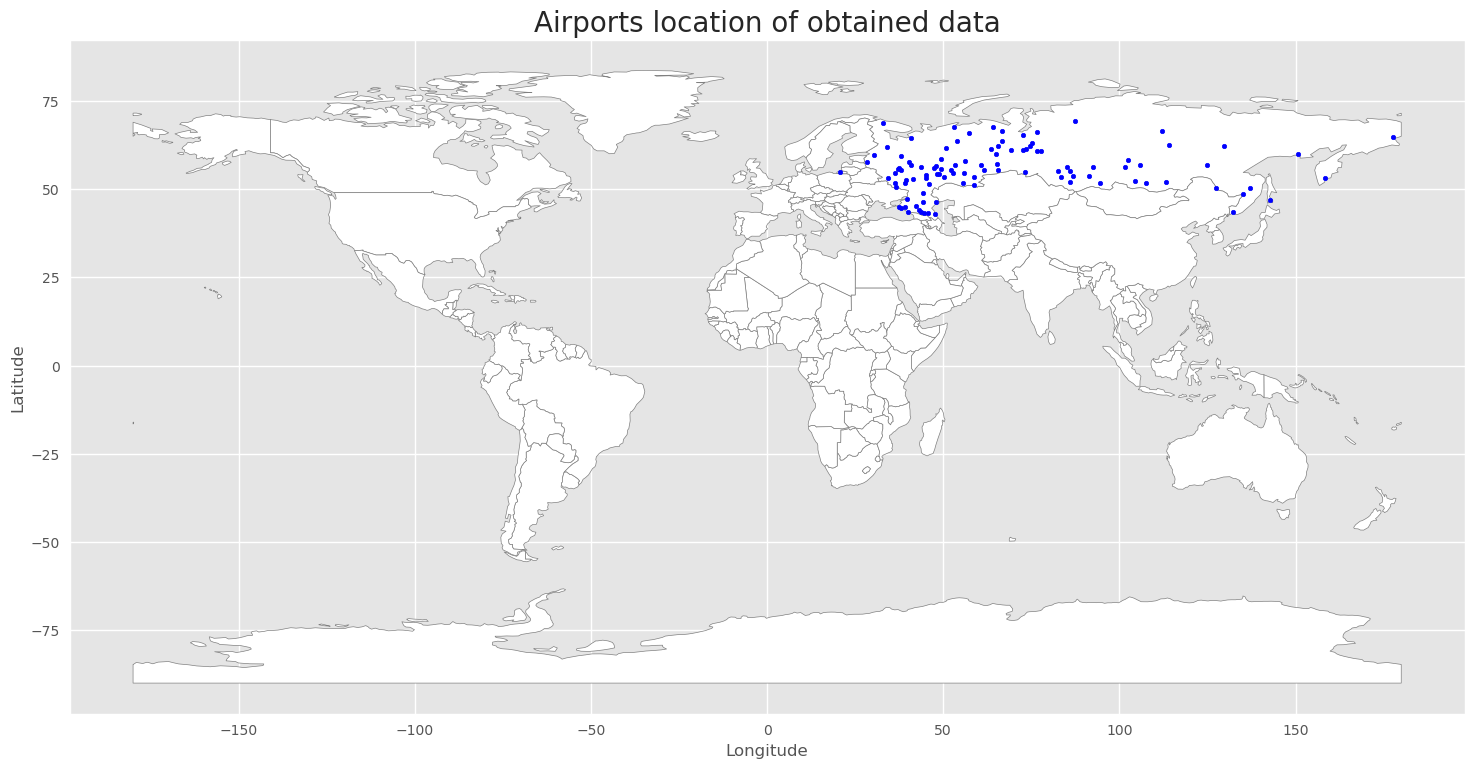

In [5]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
with plt.style.context(("seaborn", "ggplot")):    
    world.plot(figsize=(18,10),
                   color="white",
                   edgecolor = "grey")
    plt.scatter(airports_df.long, airports_df.lat, s=10, color="blue",)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Airports location of obtained data", fontsize=20)
    plt.show()

As we can see obtained data is refering only to Russia Federation

# Delays analyse

In [6]:
delay_df = flights_df.dropna(
    how='any', 
    thresh=None, 
    subset=('scheduled_departure', 'scheduled_arrival', 'actual_departure', 'actual_arrival'),
)

city_df = simplify_airport_df.select('airport_code', 'city')

delay_city = delay_df.join(city_df,delay_df.departure_airport ==  city_df.airport_code,"leftouter")
delay_city = delay_city.withColumnRenamed("city","depature_city")
delay_city = delay_city.drop("airport_code")

delay_city = delay_city.join(city_df,delay_df.arrival_airport ==  city_df.airport_code,"leftouter")
delay_city = delay_city.withColumnRenamed("city","arrival_city")
delay_city = delay_city.drop("airport_code")

rdd2=delay_city.rdd.map(
    lambda x: (
        x.flight_no, x.departure_airport, x.arrival_airport,
        x.depature_city + '-' + x.arrival_city,
        (x.actual_departure - x.scheduled_departure).total_seconds() ,
        (x.actual_arrival - x.scheduled_arrival).total_seconds(),
    )
)

df2=rdd2.toDF(
    [
        "flight_no","departure_airport","arrival_airport", "connection", 
        "departure_delay_seconds", "arrival_delay_seconds",
    ]
)
avg_del_per_conn = df2.groupBy("connection") \
            .mean("departure_delay_seconds", "arrival_delay_seconds" )

avg_del_per_conn = avg_del_per_conn.toPandas()

avg_del_per_conn['avg(departure_delay_seconds)'] = avg_del_per_conn['avg(departure_delay_seconds)'].apply(lambda x: round(x,2))
avg_del_per_conn['avg(arrival_delay_seconds)'] = avg_del_per_conn['avg(arrival_delay_seconds)'].apply(lambda x: round(x,2))
avg_del_per_conn['avg(departure_delay_minutes)'] = avg_del_per_conn['avg(departure_delay_seconds)'].apply(lambda x: round(x/60,2))
avg_del_per_conn['avg(arrival_delay_minutes)'] = avg_del_per_conn['avg(arrival_delay_seconds)'].apply(lambda x: round(x/60,2))

avg_del_per_conn.describe()

,avg(departure_delay_seconds),avg(arrival_delay_seconds),avg(departure_delay_minutes),avg(arrival_delay_minutes)
count,516.000000,516.000000,516.000000,516.000000
mean,763.371609,763.260969,12.722849,12.721143
std,193.642548,194.192043,3.227377,3.236383
min,156.230000,138.110000,2.600000,2.300000
25%,650.887500,649.617500,10.852500,10.827500
50%,751.725000,749.075000,12.530000,12.485000
75%,865.687500,863.967500,14.430000,14.402500
max,1680.000000,1715.770000,28.000000,28.600000


## Flight connections with biggest depature delay

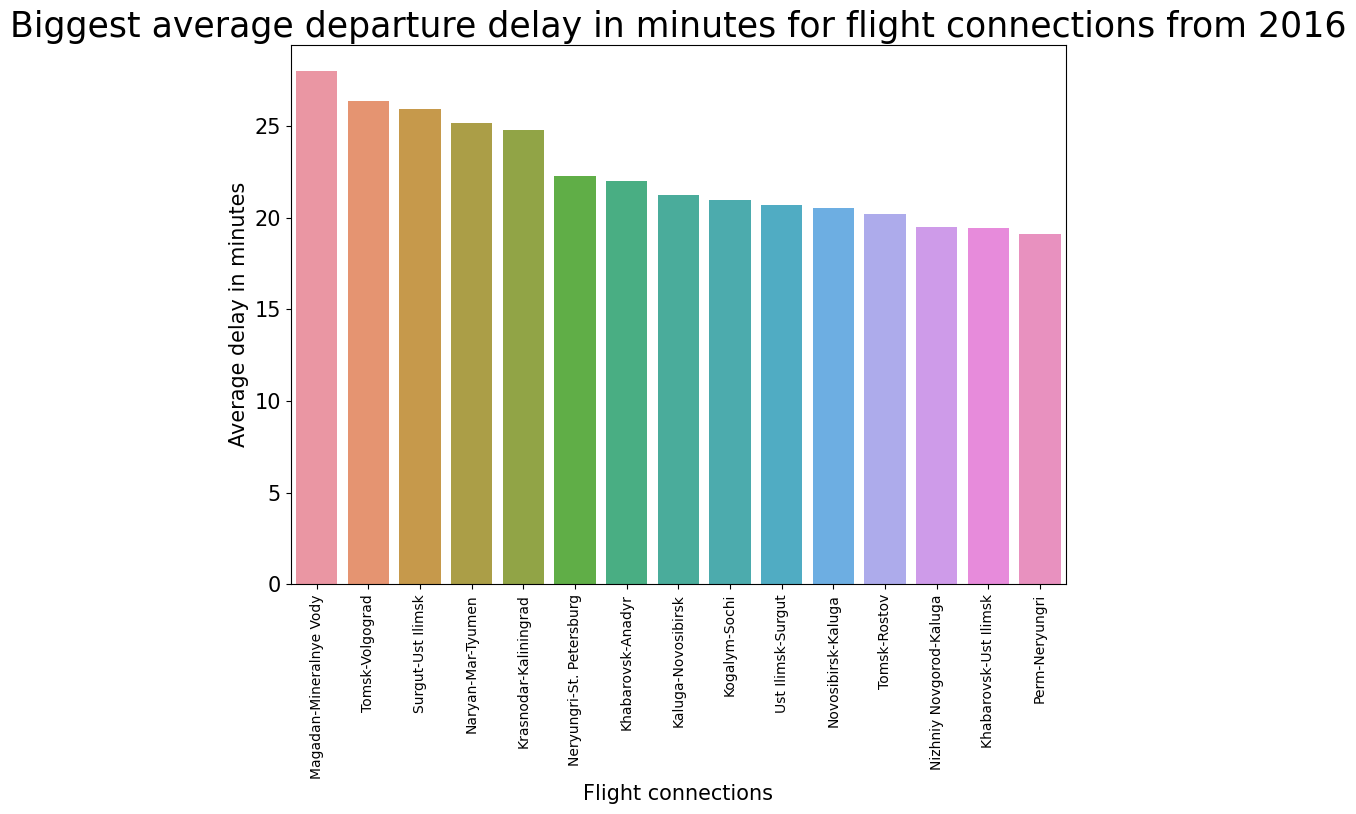

In [7]:
biggest_depature_delay = avg_del_per_conn.sort_values(
    by=['avg(departure_delay_minutes)'], 
    ascending=False
).head(15)[['connection', 'avg(departure_delay_minutes)']]

plt.figure(figsize=(10, 7))
plt.title("Biggest average departure delay in minutes for flight connections from 2016", fontsize=25)
sns.barplot(data = biggest_depature_delay, x = 'connection', y = 'avg(departure_delay_minutes)')
plt.xticks(size=10, rotation=90)
plt.yticks(size=15)
plt.xlabel("Flight connections", fontsize=15)
plt.ylabel("Average delay in minutes", fontsize=15)
plt.show()

## Flight connections with biggest arrival delay

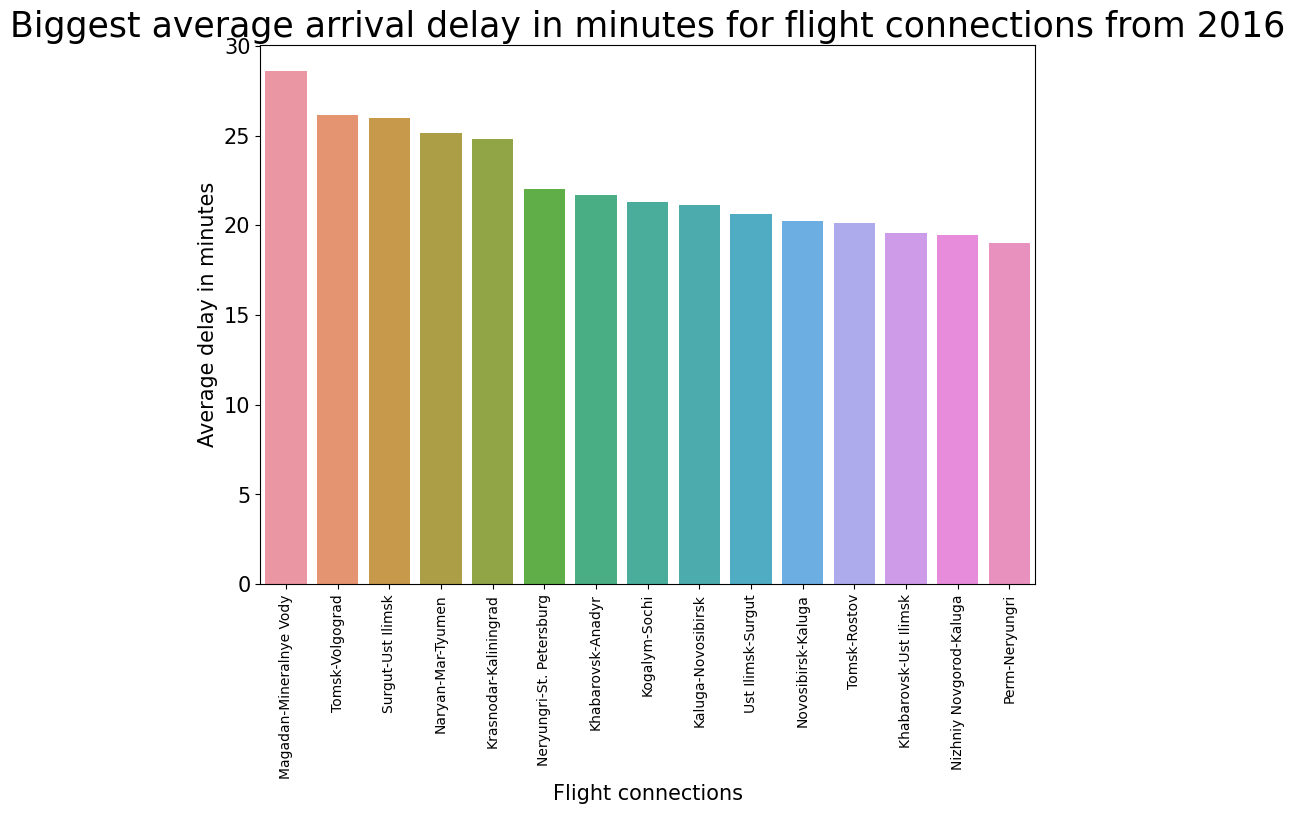

In [8]:
biggest_arrival_delay = avg_del_per_conn.sort_values(
    by=['avg(arrival_delay_minutes)'], 
    ascending=False
).head(15)[['connection', 'avg(arrival_delay_minutes)']]

plt.figure(figsize=(10, 7))
plt.title("Biggest average arrival delay in minutes for flight connections from 2016", fontsize=25)
sns.barplot(data = biggest_arrival_delay, x = 'connection', y = 'avg(arrival_delay_minutes)')
plt.xticks(size=10, rotation=90)
plt.yticks(size=15)
plt.xlabel("Flight connections", fontsize=15)
plt.ylabel("Average delay in minutes", fontsize=15)
plt.show()

# Airports with the most flights

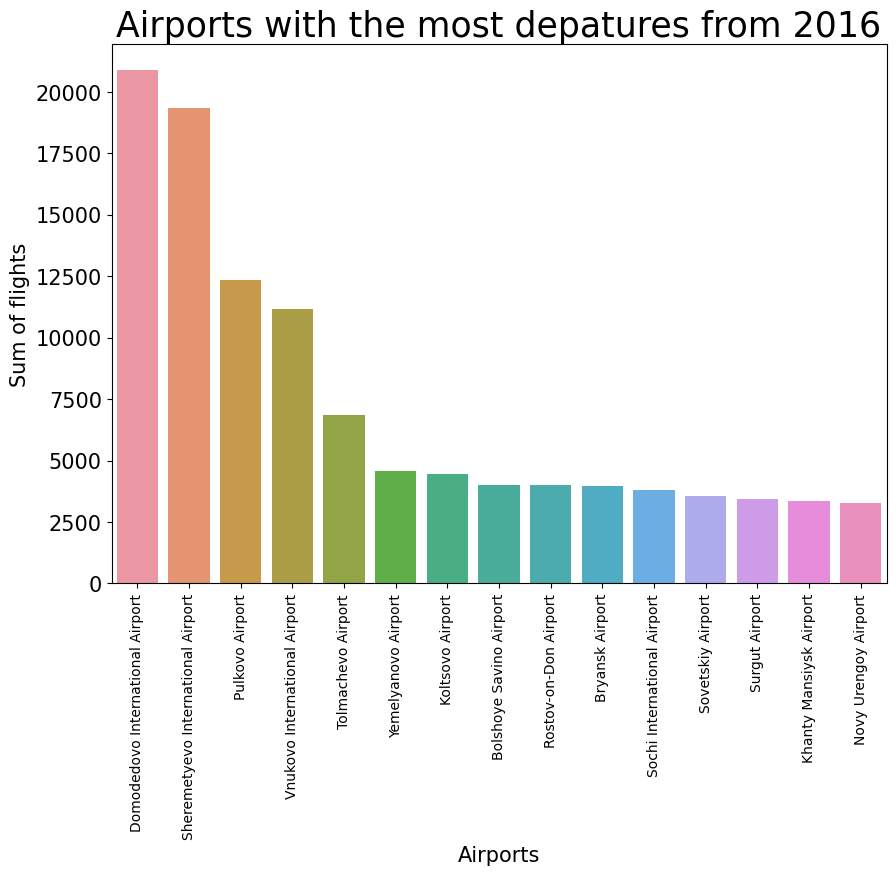

In [9]:
airports_names = simplify_airport_df.select('airport_code', 'airport_name')

most_flights = flights_df.join(airports_names,delay_df.departure_airport ==  city_df.airport_code,"leftouter")
most_flights = most_flights.withColumnRenamed("airport_name","depature_airport_name")
most_flights = most_flights.drop("airport_code")

most_depatures = most_flights.groupBy('depature_airport_name').count()

most_depatures = most_depatures.toPandas().sort_values(
    by=['count'], 
    ascending=False
).head(15)

plt.figure(figsize=(10, 7))
plt.title("Airports with the most depatures from 2016", fontsize=25)
sns.barplot(data = most_depatures, x = 'depature_airport_name', y = 'count')
plt.xticks(size=10, rotation=90)
plt.yticks(size=15)
plt.xlabel("Airports", fontsize=15)
plt.ylabel("Sum of flights", fontsize=15)
plt.show()

# Checking available seats per model

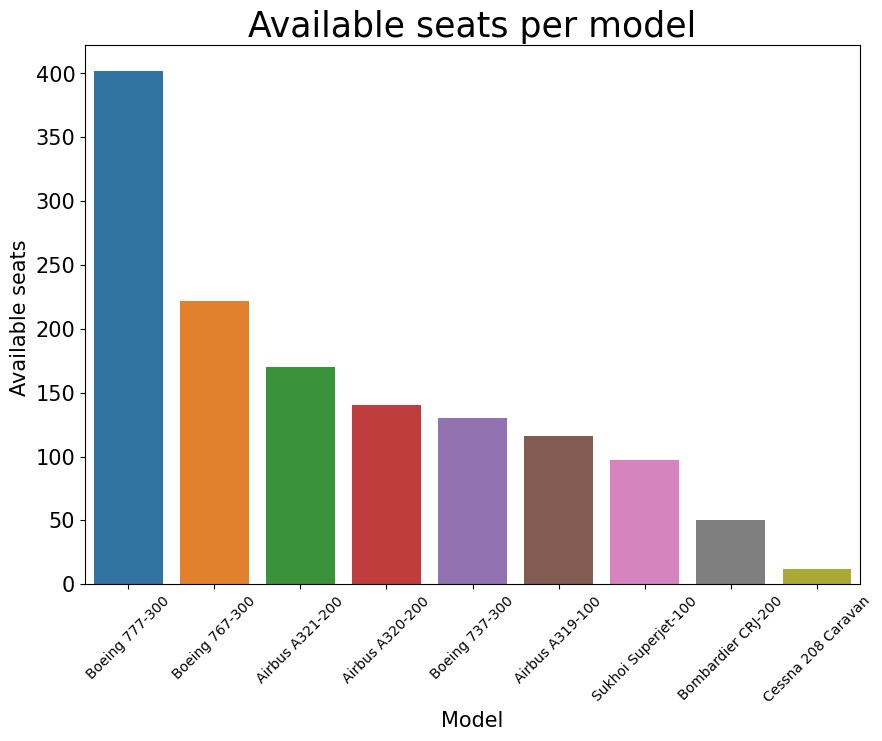

In [10]:
aircraft_num_of_seats = seats_df.groupBy('aircraft_code').count()

rdd2=aircrafts_data_df.rdd.map(
    lambda x: (
        x.aircraft_code,
        re.findall(r'"(.*?)"', x.model)[1],
        x.range
    )
)

aircrafts=rdd2.toDF(["aircraft_code", "model", "range"])

aircrafts = aircrafts.join(aircraft_num_of_seats,aircrafts.aircraft_code ==  aircraft_num_of_seats.aircraft_code,"leftouter")
aircrafts = aircrafts.withColumnRenamed("count","seats_available")
aircrafts = aircrafts.drop("aircraft_code")

# Small barplot to show aircraft available sets 
aircrafts = aircrafts.toPandas()
plt.figure(figsize=(10, 7))
plt.title("Available seats per model", fontsize=25)
sns.barplot(data = aircrafts.sort_values(by='seats_available', ascending=False), x = 'model', y = 'seats_available')
plt.xticks(size=10, rotation=45)
plt.yticks(size=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Available seats ", fontsize=15)
plt.show()

# Checking aircraft model range

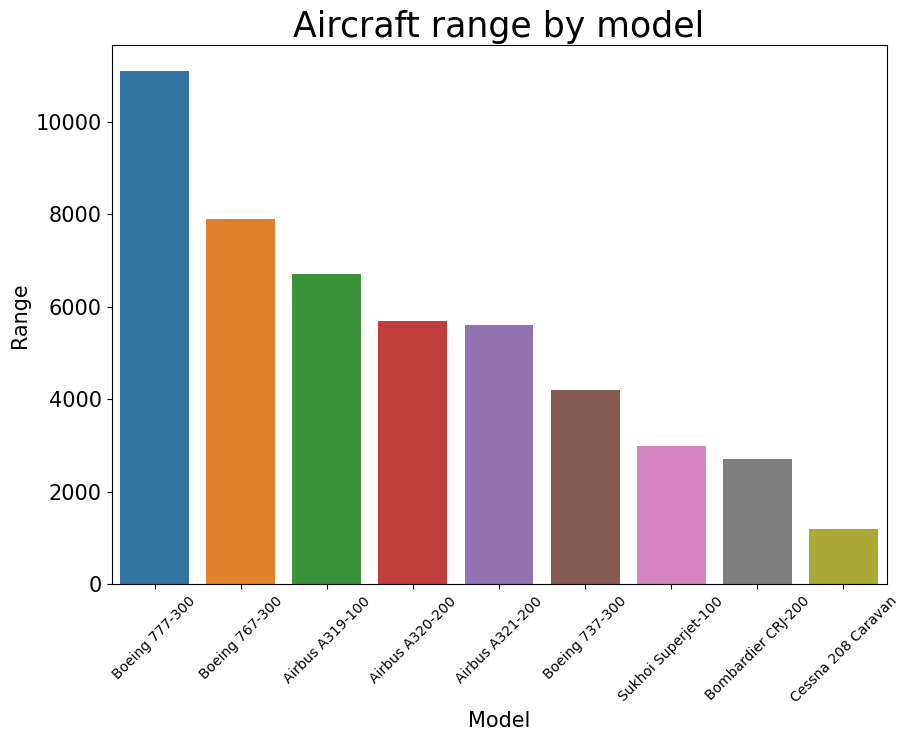

In [11]:
plt.figure(figsize=(10, 7))
plt.title("Aircraft range by model", fontsize=25)
sns.barplot(data = aircrafts.sort_values(by='range', ascending=False), x = 'model', y = 'range')
plt.xticks(size=10, rotation=45)
plt.yticks(size=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Range", fontsize=15)
plt.show()

# Most used aircraft models 

In [12]:
aircrafts_flights = flights_df.groupBy('aircraft_code').count()

aircrafts_flights.show()

+-------------+-----+
|aircraft_code|count|
+-------------+-----+
|          SU9|55213|
|          733| 8263|
|          773| 3960|
|          319| 8032|
|          CN1|60196|
|          763| 7920|
|          321|12672|
|          CR2|58611|
+-------------+-----+



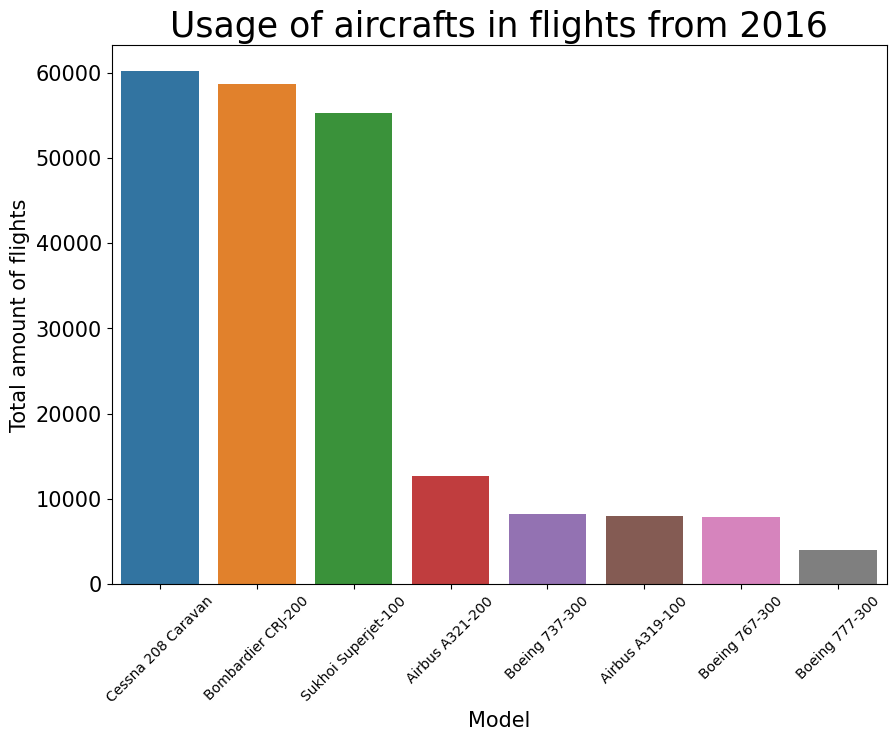

In [13]:
rdd2=aircrafts_data_df.rdd.map(
    lambda x: (
        x.aircraft_code,
        re.findall(r'"(.*?)"', x.model)[1],
        x.range
    )
)

aircrafts=rdd2.toDF(["aircraft_code", "model", "range"])

aircraft_use = aircrafts_flights.join(aircrafts,aircrafts_flights.aircraft_code ==  aircrafts.aircraft_code,"leftouter")
aircraft_use = aircraft_use.drop("aircraft_code")
aircraft_use = aircraft_use.drop("range")

plt.figure(figsize=(10, 7))
aircraft_use = aircraft_use.toPandas()
plt.title("Usage of aircrafts in flights from 2016", fontsize=25)
sns.barplot(data = aircraft_use.sort_values(by=['count'], ascending=False), x = 'model', y = 'count')
plt.xticks(size=10, rotation=45)
plt.yticks(size=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Total amount of flights", fontsize=15)
plt.show()

# Checking the number of occupied seats per flight connection

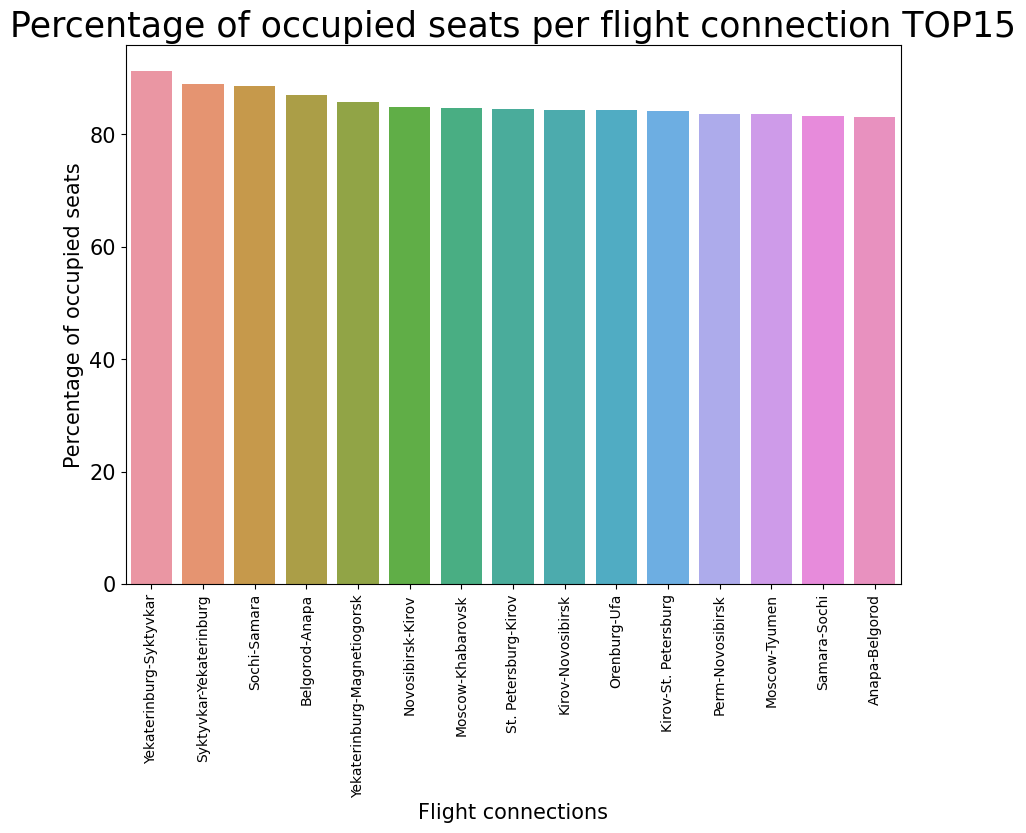

In [14]:
aircraft_num_of_seats = seats_df.groupBy('aircraft_code').count()

city_df = simplify_airport_df.select('airport_code', 'city')

connection = flights_df.select('flight_id', 'departure_airport', 'arrival_airport', 'aircraft_code')

connection = connection.join(city_df,delay_df.departure_airport ==  city_df.airport_code,"leftouter")
connection = connection.withColumnRenamed("city","depature_city")
connection = connection.drop("airport_code")

connection = connection.join(city_df,delay_df.arrival_airport ==  city_df.airport_code,"leftouter")
connection = connection.withColumnRenamed("city","arrival_city")
connection = connection.drop("airport_code")


rdd2=connection.rdd.map(
    lambda x: (
        x.flight_id,
        x.depature_city + '-' + x.arrival_city,
        x.aircraft_code,
    )
)

connection=rdd2.toDF(["flight_id", "connection", "aircraft_code"])

occ_seats_per_flight = boarding_passes_df.groupBy('flight_id')\
            .count()


combined_df = connection.join(occ_seats_per_flight,connection.flight_id ==  occ_seats_per_flight.flight_id,"leftouter")
combined_df = combined_df.withColumnRenamed("count","seats_occupied")
combined_df = combined_df.drop("flight_id")
combined_df = combined_df.join(aircraft_num_of_seats,combined_df.aircraft_code ==  aircraft_num_of_seats.aircraft_code,"leftouter")
combined_df = combined_df.withColumnRenamed("count","seats_available")
combined_df = combined_df.drop("aircraft_code")


percentage_of_seats_locked = combined_df.groupBy('connection').sum('seats_occupied', 'seats_available')
percentage_of_seats_locked = percentage_of_seats_locked.withColumnRenamed("sum(seats_occupied)","seats_occupied")
percentage_of_seats_locked = percentage_of_seats_locked.withColumnRenamed("sum(seats_available)","seats_available")

percentage_of_seats_locked = percentage_of_seats_locked.dropna(
    how='any', 
    thresh=None, 
    subset=('seats_occupied')
)

rdd2=percentage_of_seats_locked.rdd.map(
    lambda x: (
        x.connection,
        round((x.seats_occupied / x.seats_available)*100,2),
    )
)
# Return do Pyspark DataFrame
percentage_of_seats_locked=rdd2.toDF(["connection", "occupied_percentage"])

percentage_of_seats_locked = percentage_of_seats_locked.toPandas()

percentage_of_seats_locked = percentage_of_seats_locked.sort_values(
    by=['occupied_percentage'], 
    ascending=False
)

plt.figure(figsize=(10, 7))
plt.title("Percentage of occupied seats per flight connection TOP15", fontsize=25)
sns.barplot(data = percentage_of_seats_locked.head(15), x = 'connection', y = 'occupied_percentage')
plt.xticks(size=10, rotation=90)
plt.yticks(size=15)
plt.xlabel("Flight connections", fontsize=15)
plt.ylabel("Percentage of occupied seats", fontsize=15)
plt.show()

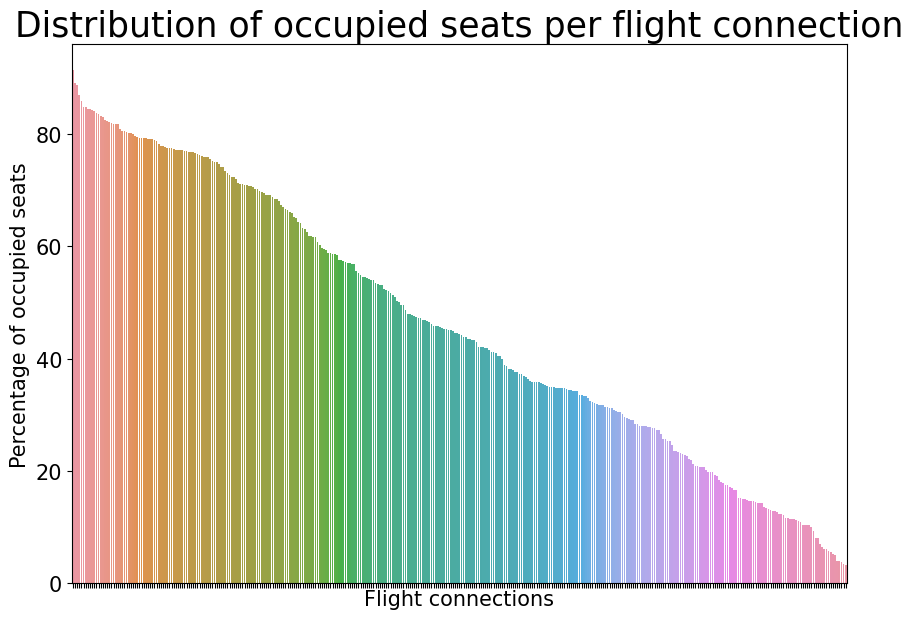

In [15]:
plt.figure(figsize=(10, 7))
plt.title("Distribution of occupied seats per flight connection", fontsize=25)
sns.barplot(data = percentage_of_seats_locked, x = 'connection', y = 'occupied_percentage')
plt.xticks(size=10, rotation=90)
plt.yticks(size=15)
plt.xlabel("Flight connections", fontsize=15)
plt.tick_params(labelbottom=False)
plt.ylabel("Percentage of occupied seats", fontsize=15)
plt.show()

# Chart of realised flights in range of time

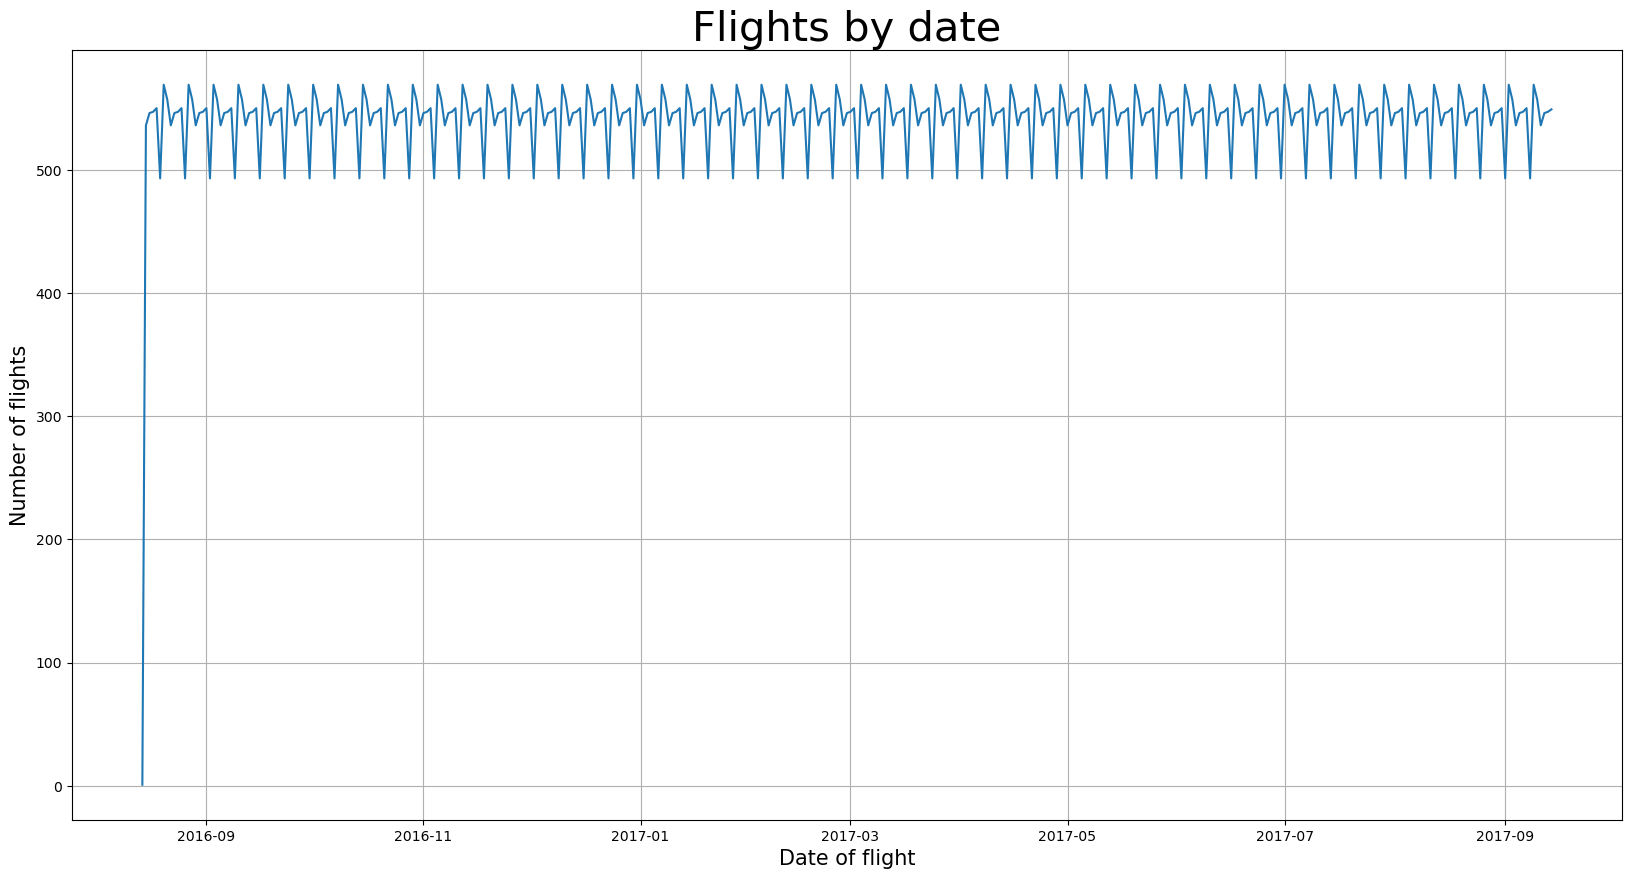

In [16]:
flights_by_day = flights_df.withColumn("date", to_date(col('scheduled_departure'), "dd-MM-yyyy"))
flights_by_day = flights_by_day.groupBy('date').count()
flights_by_day = flights_by_day.toPandas()

dates = list(flights_by_day.date.unique()) 

plt.figure(figsize=(20, 10))
sns.lineplot(data=flights_by_day.sort_values(by='date'),x='date',y='count', legend='full')
plt.title("Flights by date", fontsize=30)
plt.xlabel("Date of flight", fontsize=15)
plt.ylabel("Number of flights", fontsize=15)
plt.grid()

In [17]:
spark.catalog.clearCache()

# Chart of transported passengers in range of time

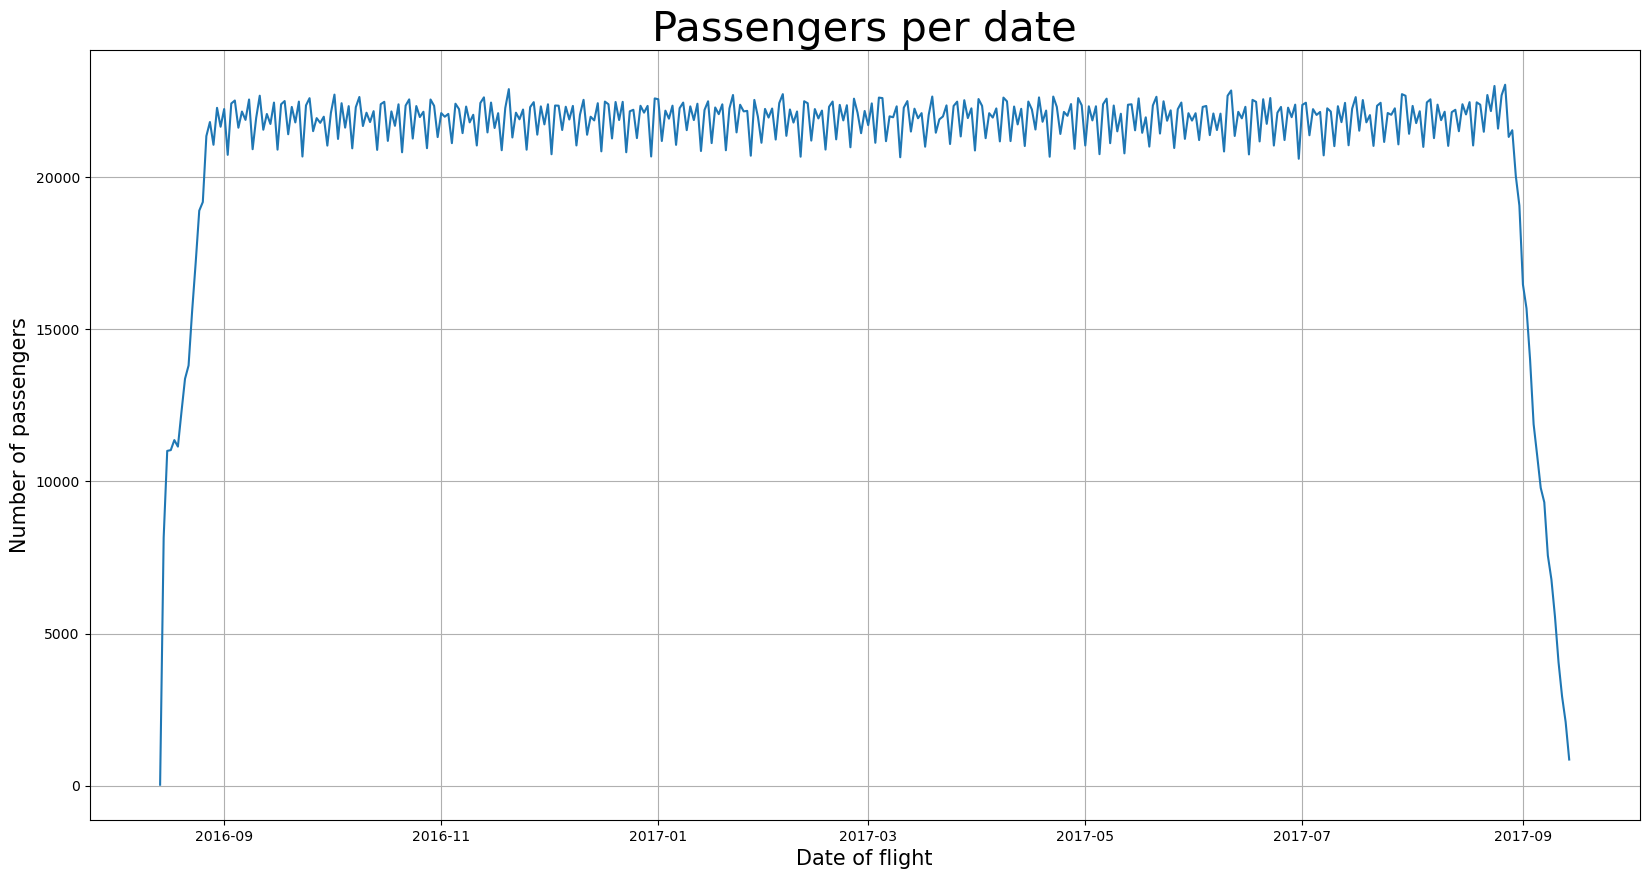

In [18]:
flights_by_day = flights_df.withColumn("date", to_date(col('scheduled_departure'), "dd-MM-yyyy"))

passengers_per_flight = ticket_flights_df.groupBy('flight_id').count()

num_of_passengers = passengers_per_flight.join(
    flights_by_day,flights_by_day.flight_id ==  passengers_per_flight.flight_id, "full"
).drop(passengers_per_flight.flight_id)
num_of_passengers = num_of_passengers.groupBy('date').sum('count')
num_of_passengers = num_of_passengers.toPandas()


plt.figure(figsize=(20, 10))
sns.lineplot(data=num_of_passengers.sort_values(by='date'),x='date',y='sum(count)', legend='full')
plt.title("Passengers per date", fontsize=30)
plt.xlabel("Date of flight", fontsize=15)
plt.ylabel("Number of passengers", fontsize=15)
plt.grid()

# Chart of served passengers per airport for biggest airports

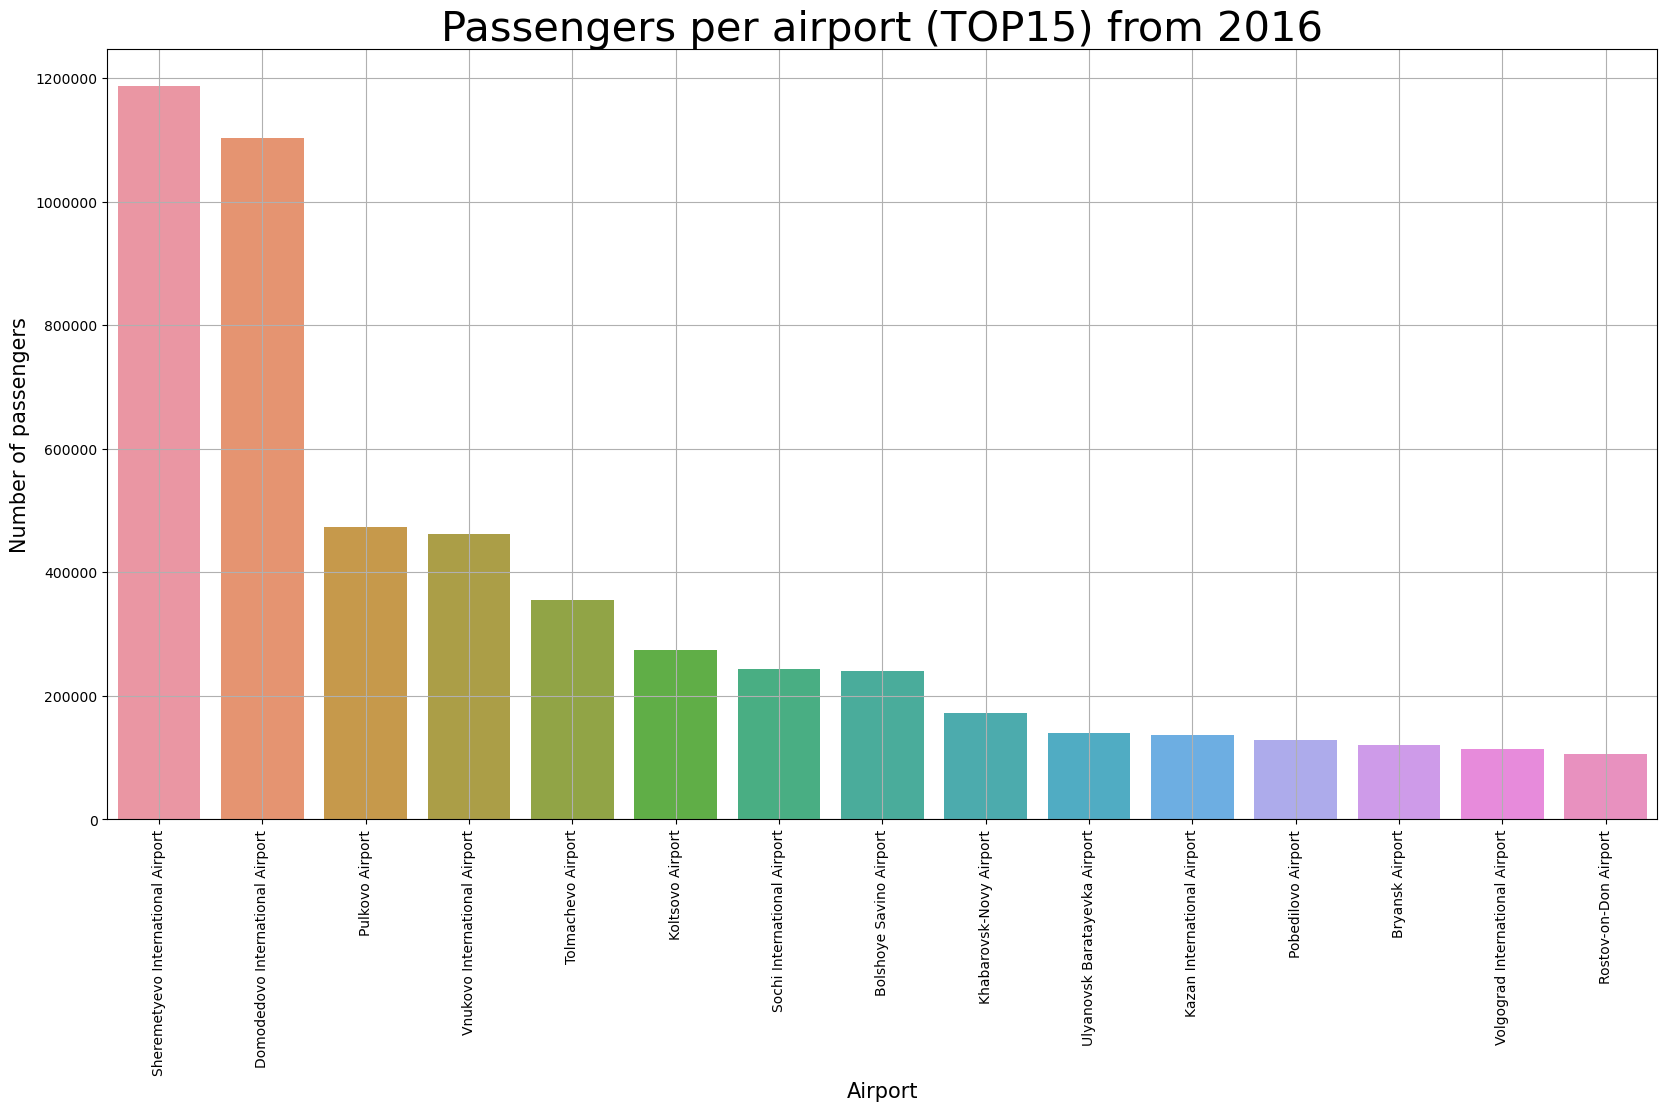

In [19]:
airports_names = simplify_airport_df.select('airport_code', 'airport_name')

passengers_per_flight = boarding_passes_df.groupBy('flight_id').count()
passengers_per_flight = passengers_per_flight.withColumnRenamed("flight_id","id_flight")

num_of_passengers = flights_df.join(
    passengers_per_flight,flights_df.flight_id ==  passengers_per_flight.id_flight,"leftouter"
)

num_of_passengers = num_of_passengers.join(
    simplify_airport_df,num_of_passengers.departure_airport ==  simplify_airport_df.airport_code,"leftouter"
)
num_of_passengers = num_of_passengers.groupBy('airport_name').sum('count')
num_of_passengers = num_of_passengers.toPandas()
num_of_passengers = num_of_passengers.dropna(how='all', subset=['sum(count)'])

plt.figure(figsize=(20, 10))
sns.barplot(data=num_of_passengers.sort_values(by='sum(count)')[::-1][:15],x='airport_name',y='sum(count)')
plt.title("Passengers per airport (TOP15) from 2016", fontsize=30)
plt.xticks(fontsize=10, rotation=90)
plt.xlabel("Airport", fontsize=15)
plt.ylabel("Number of passengers", fontsize=15)
plt.ticklabel_format(style='plain', axis='y')
plt.grid()

# Served passengers per airport on world map from 2016

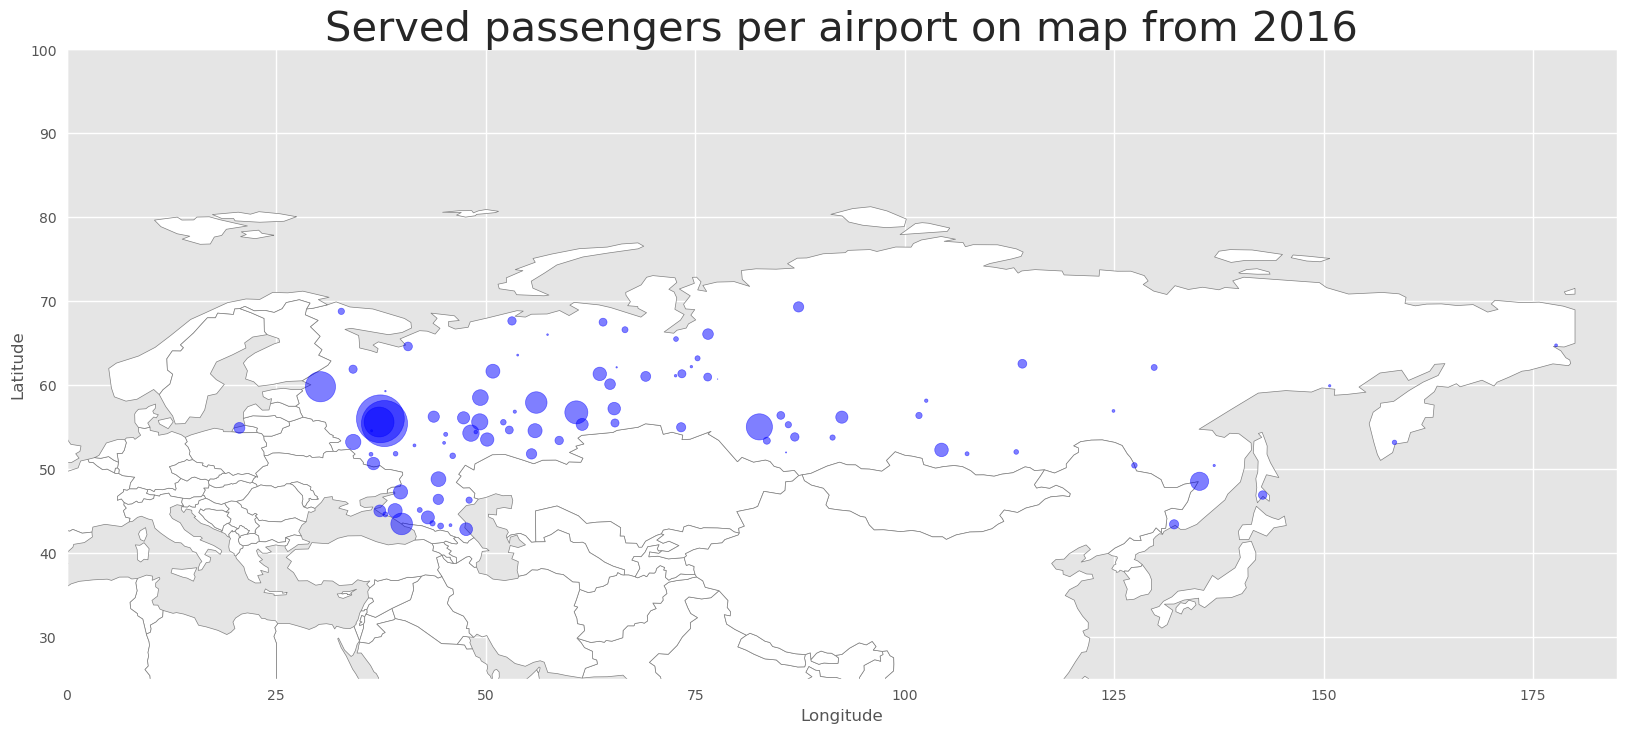

In [20]:
airports_with_coord = simplify_airport_df.select(
    'airport_code', 'airport_name', 'long', 'lat'
)

passengers_per_flight = boarding_passes_df.groupBy('flight_id').count()
passengers_per_flight = passengers_per_flight.withColumnRenamed("flight_id","id_flight")

num_of_passengers = flights_df.join(
    passengers_per_flight,flights_df.flight_id ==  passengers_per_flight.id_flight,"leftouter"
)
num_of_passengers = num_of_passengers.join(
    airports_with_coord,num_of_passengers.departure_airport ==  airports_with_coord.airport_code,"leftouter"
)
num_of_passengers = num_of_passengers.groupBy('long', 'lat').sum('count')

num_of_passengers = num_of_passengers.toPandas()

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
with plt.style.context(("seaborn", "ggplot")):    
    world.plot(figsize=(20,15),
                   color="white",
                   edgecolor = "grey")
    plt.scatter(
        num_of_passengers.long, num_of_passengers.lat, 
        s=num_of_passengers['sum(count)']/1000, color="blue",
        alpha=0.5,
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Served passengers per airport on map from 2016", fontsize=30)
    plt.xlim([0, 185])
    plt.ylim([25, 100])
    plt.show()

# Flights per airport on map from 2016

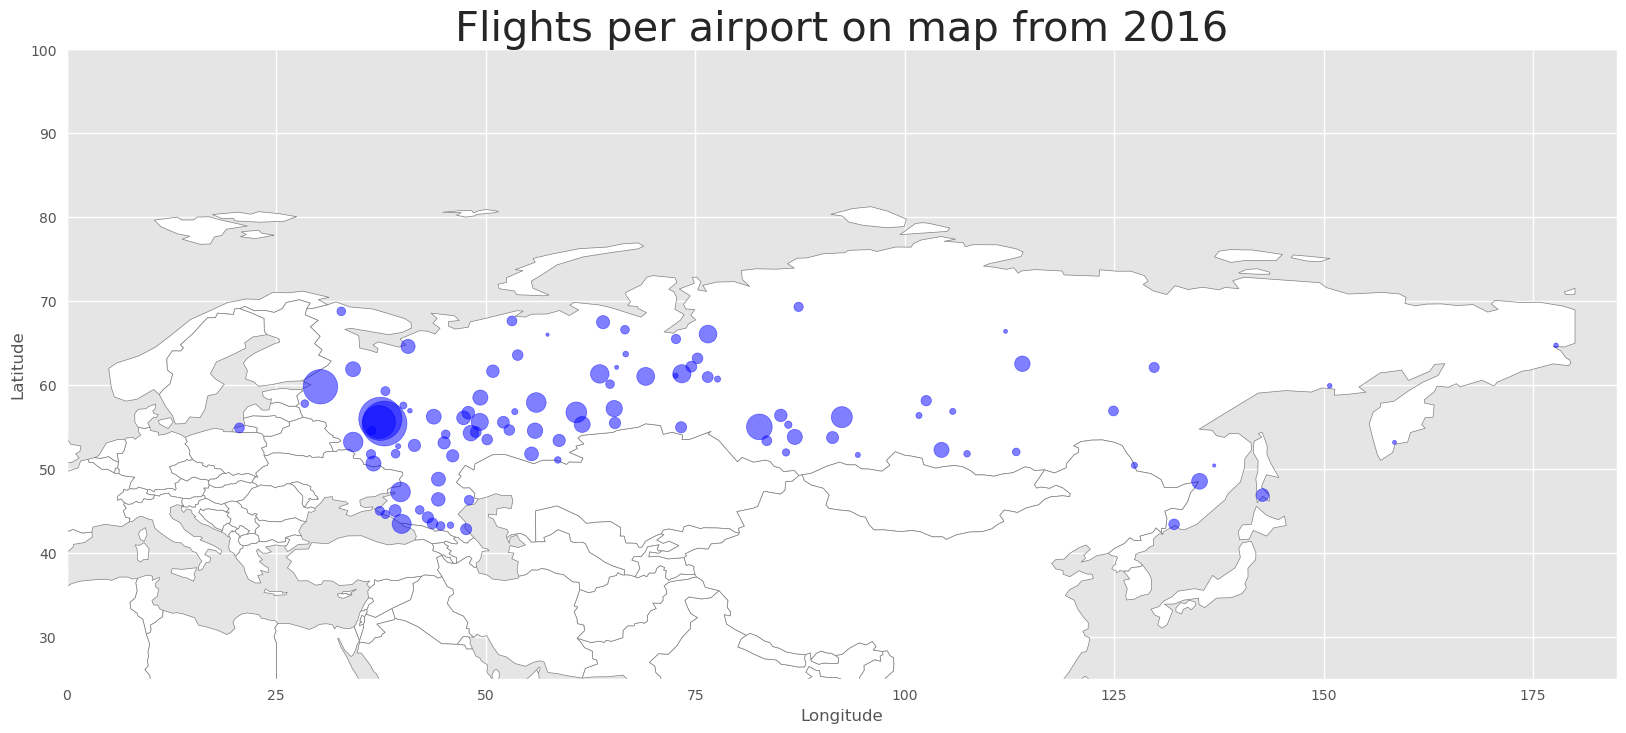

In [21]:
most_flights = flights_df.join(simplify_airport_df,delay_df.departure_airport ==  simplify_airport_df.airport_code,"leftouter")
most_flights = most_flights.withColumnRenamed("airport_name","depature_airport_name")
most_flights = most_flights.drop("airport_code")
most_flights = most_flights.groupBy('long', 'lat').count()
most_flights = most_flights.toPandas()

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
with plt.style.context(("seaborn", "ggplot")):    
    world.plot(figsize=(20,15),
                   color="white",
                   edgecolor = "grey")
    plt.scatter(
        most_flights.long, most_flights.lat, 
        s=most_flights['count']/20, color="blue",
        alpha=0.5,
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Flights per airport on map from 2016", fontsize=30)
    plt.xlim([0, 185])
    plt.ylim([25, 100])
    plt.show()

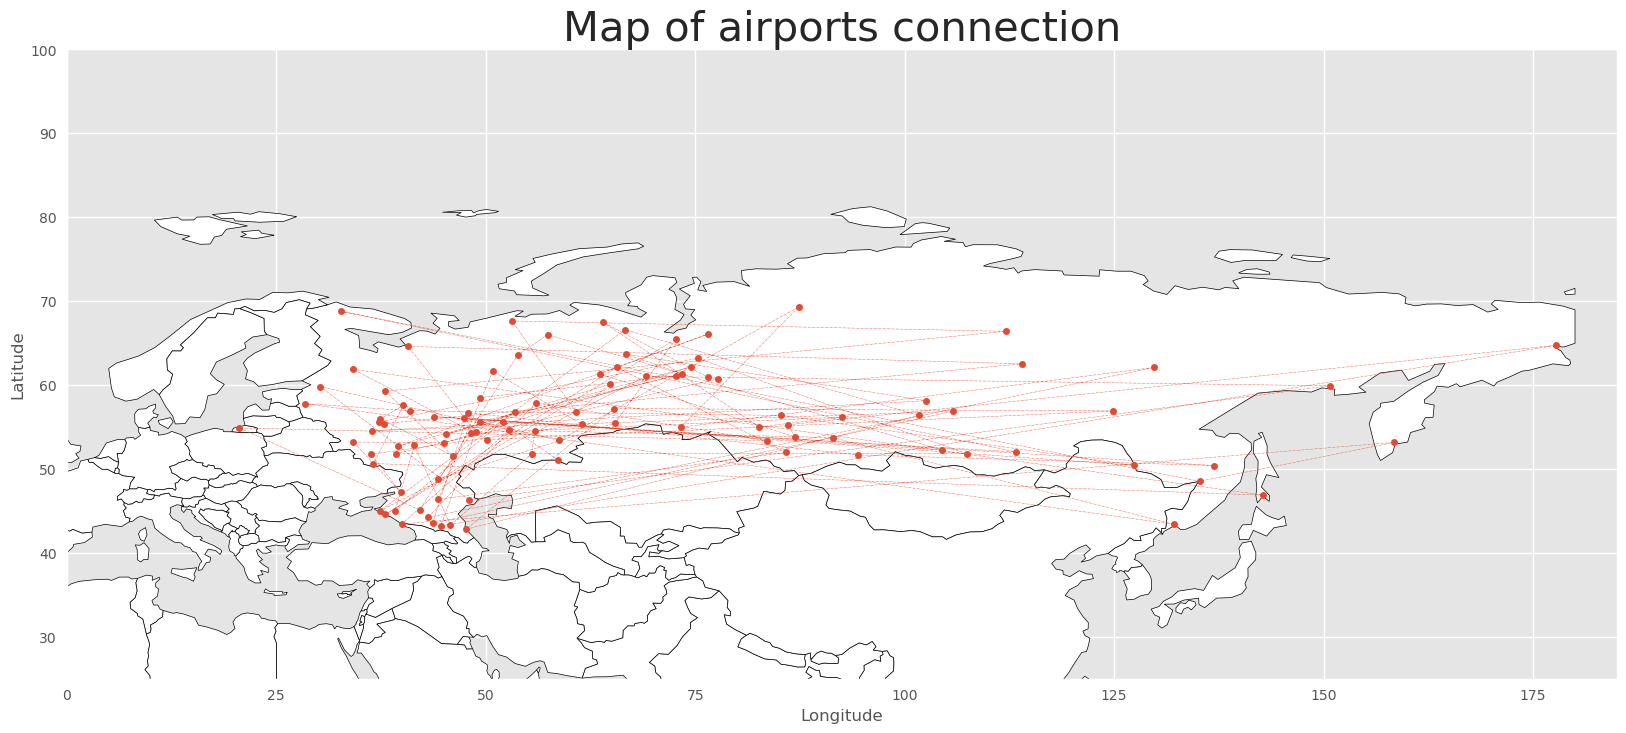

In [22]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
with plt.style.context(("seaborn", "ggplot")):    
    world.plot(figsize=(20,15),
                   color="white",
                   edgecolor = "black")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Map of airports connection", fontsize=30)
    plt.xlim([0, 185])
    plt.ylim([25, 100])
    plt.plot(most_flights['long'], most_flights['lat'], 'o-.',linewidth = 0.3, markersize=5)
    plt.show()

# Chart of booked tickets in range of time

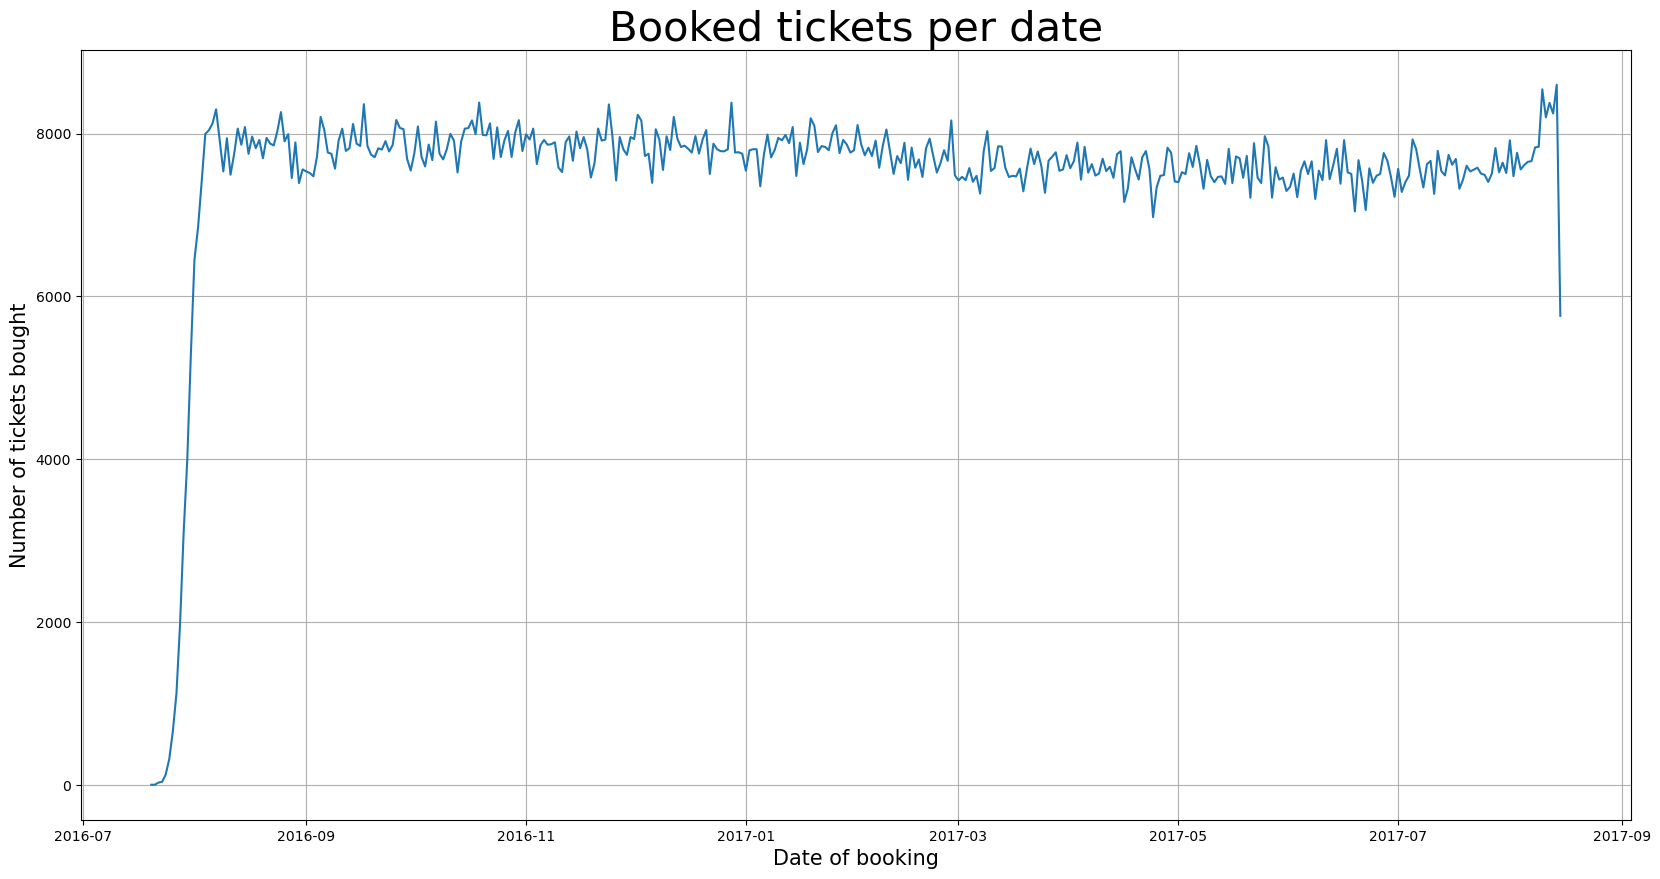

In [23]:
bookings_df = bookings_df.withColumn("date", to_date(col('book_date'), "dd-MM-yyyy"))

tickets_per_day = tickets_df.join(
    bookings_df,tickets_df.book_ref ==  bookings_df.book_ref,"leftouter"
)
tickets_per_day = tickets_per_day.groupBy('date').count()
tickets_per_day = tickets_per_day.toPandas()

dates = list(tickets_per_day.date.unique()) 

plt.figure(figsize=(20, 10))
sns.lineplot(data=tickets_per_day.sort_values(by='date'),x='date',y='count',
            legend='full')
plt.title("Booked tickets per date", fontsize=30)
plt.xlabel("Date of booking", fontsize=15)
plt.ylabel("Number of tickets bought", fontsize=15)
plt.grid()

# Description about total price of booking in RUB

In [24]:
bookings_df.describe(['total_amount']).show()

+-------+-----------------+
|summary|     total_amount|
+-------+-----------------+
|  count|          2111109|
|   mean|79409.91289412342|
| stddev|77913.35115580563|
|    min|             3400|
|    max|          1308700|
+-------+-----------------+



# Description about tickets per booking

In [25]:
avg_tickets_per_booking = bookings_df.join(tickets_df,bookings_df.book_ref ==  tickets_df.book_ref,"leftouter").drop(tickets_df.book_ref)
avg_tickets_per_booking = avg_tickets_per_booking.groupBy('book_ref').count()

avg_tickets_per_booking.describe(['count']).show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|           1448972|
|   mean|2.5579390077931112|
| stddev| 2.392221819475497|
|    min|                 1|
|    max|                48|
+-------+------------------+



# Average flights per year per passenger

In [26]:
avg_flight_per_passenger = tickets_df.join(
    ticket_flights_df,tickets_df.ticket_no ==  ticket_flights_df.ticket_no,"leftouter"
)
avg_flight_per_passenger = avg_flight_per_passenger.select('flight_id', 'passenger_id')
avg_flight_per_passenger = avg_flight_per_passenger.join(
    flights_df,avg_flight_per_passenger.flight_id ==  flights_df.flight_id,"leftouter"
)
avg_flight_per_passenger = avg_flight_per_passenger.select('passenger_id', 'scheduled_departure')

rdd2=avg_flight_per_passenger.rdd.map(
    lambda x: (
        x.passenger_id,
        str(x.scheduled_departure).split(' ')[0][:4]
    )
)

avg_flight_per_passenger=rdd2.toDF(["passenger_id", "year"])

avg_flight_per_passenger = avg_flight_per_passenger.groupBy("passenger_id", "year").count()
avg_flight_per_passenger.groupBy('year').mean().show()

+----+------------------+
|year|        avg(count)|
+----+------------------+
|2016| 5.825189679577172|
|None|1.5494438192841808|
|2017| 5.953676850473011|
+----+------------------+



## Number of served passengers per airport per day

In [27]:
tickets_per_flight = ticket_flights_df.groupBy('flight_id').count()

passengers_sum = airports_data_df.join(
    flights_df,airports_data_df.airport_code ==  flights_df.departure_airport, "leftouter"
)
passengers_sum = passengers_sum.join(
    tickets_per_flight,passengers_sum.flight_id ==  tickets_per_flight.flight_id, "leftouter"
)
passengers_sum = passengers_sum.drop('flight_id', 'airport_code', 'departure_airport')
passengers_sum = passengers_sum.withColumn(
        "date", date_format(col('scheduled_departure'), "dd-MM-yyyy")
    )
passengers_sum = passengers_sum.groupBy('airport_name', 'date').sum()
passengers_sum = passengers_sum.withColumnRenamed("sum(count)", "num_of_passengers")

split_col = pyspark.sql.functions.split(passengers_sum['airport_name'], '"')
passengers_sum = passengers_sum.withColumn('airport', split_col.getItem(3))

passengers_aggregate = passengers_sum.select('date', 'airport', 'num_of_passengers')

passengers_aggregate.show()

+----------+--------------------+-----------------+
|      date|             airport|num_of_passengers|
+----------+--------------------+-----------------+
|16-05-2017|     Bryansk Airport|              258|
|04-12-2016|    Koltsovo Airport|              520|
|29-05-2017|Khanty Mansiysk A...|              155|
|07-02-2017|      Abakan Airport|               65|
|08-05-2017|       Mirny Airport|              112|
|24-05-2017|     Pulkovo Airport|             1536|
|19-06-2017|Mineralnyye Vody ...|              176|
|01-07-2017|Vnukovo Internati...|             1245|
|28-08-2016|Domodedovo Intern...|             2875|
|23-09-2016|Domodedovo Intern...|             2800|
|07-07-2017|Domodedovo Intern...|             2929|
|21-10-2016|    Noyabrsk Airport|               21|
|10-07-2017|  Cheboksary Airport|              236|
|22-03-2017|  Tolmachevo Airport|              848|
|13-09-2016|      Tambow Airport|               36|
|16-12-2016|Yuzhno-Sakhalinsk...|              215|
|07-02-2017|

## Daily average depature delay per airport

In [28]:
departure_delay_aggregate_df = flights_df.select(
    'scheduled_departure', 'actual_departure', 'departure_airport',
)
departure_delay_aggregate_df = departure_delay_aggregate_df.dropna(
    how='any',
    thresh=None,
    subset=('scheduled_departure', 'actual_departure'),
)
departure_delay_aggregate_df = departure_delay_aggregate_df.join(
    airports_data_df,
    departure_delay_aggregate_df.departure_airport == airports_data_df.airport_code,
    "leftouter"
)

split_col = pyspark.sql.functions.split(departure_delay_aggregate_df['airport_name'], '"')
departure_delay_aggregate_df = departure_delay_aggregate_df.withColumn('airport', split_col.getItem(3))

departure_delay_aggregate_df = departure_delay_aggregate_df.withColumn(
    "date", to_date(col('scheduled_departure'), "dd-MM-yyyy")
)
departure_delay_aggregate_df = departure_delay_aggregate_df.withColumn(
    'delay_seconds',
    departure_delay_aggregate_df['actual_departure'].cast('integer') - departure_delay_aggregate_df['scheduled_departure'].cast('integer')
)
departure_delay_aggregate_df = departure_delay_aggregate_df.groupBy('airport', 'date').mean()
departure_delay_aggregate_df = departure_delay_aggregate_df.withColumn(
    'avg_delay_in_minutes',
    departure_delay_aggregate_df['avg(delay_seconds)'] / 60
)
departure_delay_aggregate_df = departure_delay_aggregate_df.select(
    'date', 'airport', 'avg_delay_in_minutes'
)

departure_delay_aggregate_df.show()

+----------+--------------------+--------------------+
|      date|             airport|avg_delay_in_minutes|
+----------+--------------------+--------------------+
|2016-12-29|Domodedovo Intern...|   9.907407407407408|
|2017-02-01|Vnukovo Internati...|                17.5|
|2016-10-06|Sheremetyevo Inte...|  6.4897959183673475|
|2017-01-03|Sheremetyevo Inte...|  17.725490196078432|
|2016-09-04|     Pulkovo Airport|            28.03125|
|2017-02-13|     Pulkovo Airport|  21.387096774193548|
|2017-05-23|     Pulkovo Airport|  3.1666666666666665|
|2017-03-04|     Pulkovo Airport|               9.625|
|2017-03-17|     Pulkovo Airport|   3.466666666666667|
|2017-08-03|     Pulkovo Airport|                22.5|
|2017-01-25|  Tolmachevo Airport|  14.470588235294118|
|2017-02-06|    Koltsovo Airport|                3.25|
|2017-03-20|    Koltsovo Airport|  21.583333333333332|
|2016-12-16|Kazan Internation...|  27.714285714285715|
|2016-10-28|Chelyabinsk Balan...|                40.0|
|2016-12-0

## Daily average booking per airport

In [29]:
book_per_airport = bookings_df.join(
    tickets_df, bookings_df.book_ref == tickets_df.book_ref, 
    "leftouter"
)
book_per_airport = book_per_airport.join(
    ticket_flights_df, book_per_airport.ticket_no == ticket_flights_df.ticket_no, 
    "leftouter"
)
book_per_airport = book_per_airport.join(
    flights_df, book_per_airport.flight_id == flights_df.flight_id, 
    "leftouter"
)
book_per_airport = book_per_airport.join(
    airports_data_df, 
    book_per_airport.departure_airport == airports_data_df.airport_code,
    "leftouter",
)
book_per_airport = book_per_airport.select(
    'total_amount', 'book_date', 'airport_name'
)

split_col = pyspark.sql.functions.split(book_per_airport['airport_name'], '"')
book_per_airport = book_per_airport.withColumn('airport', split_col.getItem(3))
book_per_airport = book_per_airport.withColumn(
    "date", date_format(col('book_date'), "dd-MM-yyyy")
)

book_per_airport = book_per_airport.groupBy('airport', 'date').count()
book_per_airport = book_per_airport.withColumnRenamed("count", "num_of_bookings")
book_per_airport = book_per_airport.select('date', 'airport', 'num_of_bookings')

book_per_airport.show()

+----------+--------------------+---------------+
|      date|             airport|num_of_bookings|
+----------+--------------------+---------------+
|21-04-2017| Yemelyanovo Airport|            300|
|31-07-2017| Yemelyanovo Airport|            339|
|04-08-2017|     Pulkovo Airport|           2245|
|21-04-2017|Domodedovo Intern...|           3078|
|02-02-2017|Khabarovsk-Novy A...|            518|
|13-03-2017|Khabarovsk-Novy A...|            719|
|17-08-2016|Sheremetyevo Inte...|           2619|
|17-08-2016|Kurumoch Internat...|             65|
|01-11-2016|Kurumoch Internat...|            107|
|15-04-2017|Kurumoch Internat...|            119|
|07-10-2016|Kurumoch Internat...|             98|
|24-01-2017|    Koltsovo Airport|            289|
|22-10-2016|Vnukovo Internati...|           1821|
|18-01-2017|Sochi Internation...|            530|
|21-05-2017|Kazan Internation...|            765|
|28-05-2017|Kazan Internation...|            912|
|07-05-2017|  Tolmachevo Airport|            647|


## Daily aggregate of number of flights to arrival airport

In [30]:
flights_to_arrival = flights_df.join(
    airports_data_df, flights_df.arrival_airport == airports_data_df.airport_code,
    "leftouter"
)

split_col = pyspark.sql.functions.split(flights_to_arrival['airport_name'], '"')
flights_to_arrival = flights_to_arrival.withColumn(
    'arrival_airport', split_col.getItem(3)
)
flights_to_arrival = flights_to_arrival.withColumn(
    "date", date_format(col('scheduled_arrival'), "dd-MM-yyyy")
)
flights_to_arrival = flights_to_arrival.groupBy('arrival_airport', 'date').count()
flights_to_arrival = flights_to_arrival.withColumnRenamed(
    "count", "num_of_flights"
)
flights_to_arrival = flights_to_arrival.select(
    'date', 'arrival_airport', 'num_of_flights'
)

flights_to_arrival.show()

+----------+--------------------+--------------+
|      date|     arrival_airport|num_of_flights|
+----------+--------------------+--------------+
|04-08-2017|     Pulkovo Airport|            30|
|03-01-2017|  Tolmachevo Airport|            17|
|07-05-2017|  Tolmachevo Airport|            17|
|17-05-2017|  Tolmachevo Airport|            17|
|29-09-2016|Kazan Internation...|             7|
|26-02-2017|Kazan Internation...|             8|
|05-11-2016|Kazan Internation...|             9|
|21-05-2017|Kazan Internation...|             8|
|28-03-2017|Kazan Internation...|             7|
|27-01-2017|Kazan Internation...|             7|
|28-05-2017|Kazan Internation...|             8|
|03-06-2017|Kazan Internation...|             9|
|17-08-2016|Kurumoch Internat...|             3|
|01-11-2016|Kurumoch Internat...|             3|
|15-04-2017|Kurumoch Internat...|             3|
|07-10-2016|Kurumoch Internat...|             3|
|26-10-2016|Rostov-on-Don Air...|            10|
|29-07-2017|Rostov-o

## Daily average flight occupancy per airport

In [31]:
tickets_in_flight = ticket_flights_df.groupBy('flight_id').count()
tickets_in_flight = tickets_in_flight.withColumnRenamed(
    "count", "num_of_passengers"
)
seats = seats_df.withColumnRenamed("aircraft_code", "aircraft_c")
seats_per_aircraft = seats.groupBy('aircraft_c').count()
seats_per_aircraft = seats_per_aircraft.join(
    aircrafts_data_df, 
    seats_per_aircraft.aircraft_c == aircrafts_data_df.aircraft_code,
    "leftouter"
)
seats_per_aircraft = seats_per_aircraft.withColumnRenamed("count", "num_of_seats")

avg_occupancy = flights_df.join(
    tickets_in_flight, 
    flights_df.flight_id == tickets_in_flight.flight_id,
    "leftouter"
)
avg_occupancy = avg_occupancy.join(
    seats_per_aircraft, 
    avg_occupancy.aircraft_code == seats_per_aircraft.aircraft_code,
    "leftouter"
)
avg_occupancy = avg_occupancy.join(
    airports_data_df, 
    avg_occupancy.departure_airport == airports_data_df.airport_code, 
    "leftouter"
)

split_col = pyspark.sql.functions.split(avg_occupancy['airport_name'], '"')
avg_occupancy = avg_occupancy.withColumn('airport', split_col.getItem(3))

avg_occupancy = avg_occupancy.select('airport', 'scheduled_departure', 'num_of_seats', 'num_of_passengers')
avg_occupancy = avg_occupancy.withColumn('occupancy_%', 
        (avg_occupancy['num_of_passengers'] / avg_occupancy['num_of_seats']) * 100
)
avg_occupancy = avg_occupancy.withColumn(
    "date", date_format(col('scheduled_departure'), "dd-MM-yyyy")
)
avg_occupancy = avg_occupancy.groupBy('airport', 'date').mean()
avg_occupancy = avg_occupancy.withColumn(
    "avg_occupancy_%",
    format_number("avg(occupancy_%)", 2)
)
avg_occupancy = avg_occupancy.select('date', 'airport', 'avg_occupancy_%')

avg_occupancy.show()

+----------+--------------------+---------------+
|      date|             airport|avg_occupancy_%|
+----------+--------------------+---------------+
|30-06-2017|Domodedovo Intern...|          75.91|
|17-08-2016|Sheremetyevo Inte...|          55.30|
|17-03-2017|Bolshoye Savino A...|          96.12|
|19-03-2017|Volgograd Interna...|          62.63|
|03-08-2017|Novy Urengoy Airport|         108.10|
|17-10-2016|Nizhny Novgorod S...|          41.52|
|01-03-2017|   Bogashevo Airport|         156.10|
|20-05-2017|Magnitogorsk Inte...|          71.50|
|13-01-2017|    Murmansk Airport|          26.53|
|06-12-2016|       Ukhta Airport|         116.67|
|20-11-2016|   Bogashevo Airport|         111.39|
|20-09-2016|      Talagi Airport|         131.08|
|30-05-2017|      Talagi Airport|         100.67|
|02-08-2017|Domodedovo Intern...|          71.84|
|21-04-2017| Yemelyanovo Airport|         126.19|
|01-10-2016|Ulyanovsk Baratay...|          49.71|
|06-11-2016|Domodedovo Intern...|          75.60|


## Average of seats occupied per fare conditions per day per airport

In [ ]:
num_of_seats_per_aircraft_df = seats_df.groupBy('aircraft_code', 'fare_conditions') .count()
num_of_seats_economy_per_aircraft_df = num_of_seats_per_aircraft_df.filter(
    num_of_seats_per_aircraft_df['fare_conditions'] == 'Economy'
)
num_of_seats_business_per_aircraft_df = num_of_seats_per_aircraft_df.filter(
    num_of_seats_per_aircraft_df['fare_conditions'] == 'Business'
)
num_of_seats_comfort_per_aircraft_df = num_of_seats_per_aircraft_df.filter(
    num_of_seats_per_aircraft_df['fare_conditions'] == 'Comfort'
)
num_of_seats_economy_per_aircraft_df = num_of_seats_economy_per_aircraft_df.withColumnRenamed(
    'count', 'num_of_seats_economy_per_aircraft'
).drop('fare_conditions')
num_of_seats_business_per_aircraft_df = num_of_seats_business_per_aircraft_df.withColumnRenamed(
    'count', 'num_of_seats_business_per_aircraft'
).drop('fare_conditions')
num_of_seats_business_per_aircraft_df = num_of_seats_business_per_aircraft_df.withColumnRenamed(
    'aircraft_code', 'aircraft_code_b'
)
num_of_seats_comfort_per_aircraft_df = num_of_seats_comfort_per_aircraft_df.withColumnRenamed(
    'count', 'num_of_seats_comfort_per_aircraft'
).drop('fare_conditions')
num_of_seats_comfort_per_aircraft_df = num_of_seats_comfort_per_aircraft_df.withColumnRenamed(
    'aircraft_code', 'aircraft_code_c'
)
num_of_seats_per_aircraft_df = num_of_seats_economy_per_aircraft_df.join(
    num_of_seats_comfort_per_aircraft_df,
    num_of_seats_economy_per_aircraft_df.aircraft_code == num_of_seats_comfort_per_aircraft_df.aircraft_code_c,
    'left'
)
num_of_seats_per_aircraft_df = num_of_seats_per_aircraft_df.join(
    num_of_seats_business_per_aircraft_df, 
    num_of_seats_per_aircraft_df.aircraft_code == num_of_seats_business_per_aircraft_df.aircraft_code_b,
    'left'
)
num_of_seats_per_aircraft_df = num_of_seats_per_aircraft_df.select(
    'aircraft_code',
    'num_of_seats_economy_per_aircraft',
    'num_of_seats_business_per_aircraft',
    'num_of_seats_comfort_per_aircraft'
)
passengers_per_flight_df = ticket_flights_df.groupBy('flight_id', 'fare_conditions').count()
passengers_per_flight_in_economy_df = passengers_per_flight_df.filter(
    passengers_per_flight_df['fare_conditions'] == 'Economy'
)
passengers_per_flight_in_business_df = passengers_per_flight_df.filter(
    passengers_per_flight_df['fare_conditions'] == 'Business'
)
passengers_per_flight_in_comfort_df = passengers_per_flight_df.filter(
    passengers_per_flight_df['fare_conditions'] == 'Comfort'
)
passengers_per_flight_in_economy_df = passengers_per_flight_in_economy_df.withColumnRenamed(
    'count', 'passengers_per_flight_in_economy'
).drop('fare_conditions')
passengers_per_flight_in_business_df = passengers_per_flight_in_business_df.withColumnRenamed(
    'count', 'passengers_per_flight_in_business'
).drop('fare_conditions')
passengers_per_flight_in_business_df = passengers_per_flight_in_business_df.withColumnRenamed(
    'flight_id', 'flight_id_b'
)
passengers_per_flight_in_comfort_df = passengers_per_flight_in_comfort_df.withColumnRenamed(
    'count', 'passengers_per_flight_in_comfort'
).drop('fare_conditions')
passengers_per_flight_in_comfort_df = passengers_per_flight_in_comfort_df.withColumnRenamed(
    'flight_id', 'flight_id_c'
)
passengers_per_flight_df = passengers_per_flight_in_economy_df.join(
    passengers_per_flight_in_comfort_df,
    passengers_per_flight_in_economy_df.flight_id == passengers_per_flight_in_comfort_df.flight_id_c,
    'left'
)
passengers_per_flight_df = passengers_per_flight_df.join(
    passengers_per_flight_in_business_df,
    passengers_per_flight_df.flight_id == passengers_per_flight_in_business_df.flight_id_b,
    'left'
)
passengers_per_flight_df = passengers_per_flight_df.select(
    'flight_id',
    'passengers_per_flight_in_comfort',
    'passengers_per_flight_in_business',
    'passengers_per_flight_in_economy',
)
flight_occupancy_per_fare_aggregate_df = flights_df.join(
    passengers_per_flight_df, 
    flights_df.flight_id == passengers_per_flight_df.flight_id,
    'fullouter'
)
flight_occupancy_per_fare_aggregate_df = flight_occupancy_per_fare_aggregate_df.join(
    num_of_seats_per_aircraft_df, ['aircraft_code']
)
flight_occupancy_per_fare_aggregate_df = airports_data_df.join(
    flight_occupancy_per_fare_aggregate_df,
    airports_data_df.airport_code== flight_occupancy_per_fare_aggregate_df.departure_airport,
    "leftouter"
)

split_col = pyspark.sql.functions.split(flight_occupancy_per_fare_aggregate_df['airport_name'], '"')
flight_occupancy_per_fare_aggregate_df = flight_occupancy_per_fare_aggregate_df.withColumn(
    'airport', split_col.getItem(3)
)

flight_occupancy_per_fare_aggregate_df = flight_occupancy_per_fare_aggregate_df.withColumn(
    "date", to_date(col('scheduled_departure'), "dd-MM-yyyy")
)
flight_occupancy_per_fare_aggregate_df = flight_occupancy_per_fare_aggregate_df.groupBy('date', 'airport') \
    .sum(
    'passengers_per_flight_in_economy', 'num_of_seats_economy_per_aircraft',
    'passengers_per_flight_in_business', 'num_of_seats_business_per_aircraft',
    'passengers_per_flight_in_comfort', 'num_of_seats_comfort_per_aircraft'
)
flight_occupancy_per_fare_aggregate_df = flight_occupancy_per_fare_aggregate_df.withColumn(
    'avg_occ_economy_percent',
    (flight_occupancy_per_fare_aggregate_df['sum(passengers_per_flight_in_economy)'] / flight_occupancy_per_fare_aggregate_df['sum(num_of_seats_economy_per_aircraft)']) * 100
)
flight_occupancy_per_fare_aggregate_df = flight_occupancy_per_fare_aggregate_df.withColumn(
    'avg_occ_business_percent',
    (flight_occupancy_per_fare_aggregate_df['sum(passengers_per_flight_in_business)'] / flight_occupancy_per_fare_aggregate_df['sum(num_of_seats_business_per_aircraft)']) * 100
)
flight_occupancy_per_fare_aggregate_df = flight_occupancy_per_fare_aggregate_df.withColumn(
    'avg_occ_comfort_percent',
    (flight_occupancy_per_fare_aggregate_df['sum(passengers_per_flight_in_comfort)'] / flight_occupancy_per_fare_aggregate_df['sum(num_of_seats_comfort_per_aircraft)']) * 100
)
flight_occupancy_per_fare_aggregate_df = flight_occupancy_per_fare_aggregate_df.select(
    'date', 'airport', 'avg_occ_economy_percent', 'avg_occ_business_percent', 'avg_occ_comfort_percent'
)

flight_occupancy_per_fare_aggregate_df.show()